# Workshop 8. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [66]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [67]:
cats = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=cats, shuffle=True)
test = fetch_20newsgroups(subset='test', categories=cats, shuffle=True)

Выведите по 1 тексту для каждой из категории.

In [68]:
for cat in cats:
    id = train.target_names.index(cat)
    tid = (train.target == id).argmax()

    print(f"category: {cat}\n")
    print(train.data[tid])
    print()

category: alt.atheism

From: dpw@sei.cmu.edu (David Wood)
Subject: Request for Support
Organization: Software Engineering Institute
Lines: 35



I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english')

trainV = vec.fit_transform(train.data)
testV = vec.transform(test.data)

vec.get_feature_names_out()

array(['00', '000', '0000', ..., 'ªl',
       'º_________________________________________________º_____________________º',
       'ºnd'], dtype=object)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных,
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [70]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import cross_val_score
clf = MultinomialNB()
print(f'mean cross val score: {np.mean(cross_val_score(clf, trainV, train.target, cv=5, scoring="accuracy"))}')

clf.fit(trainV, train.target)

pred = clf.predict(testV)


cross val score: 0.9626354074629937


                    precision    recall  f1-score   support

       alt.atheism       0.82      0.90      0.86       319
     comp.graphics       0.95      0.96      0.95       389
         sci.space       0.94      0.96      0.95       394
talk.religion.misc       0.87      0.74      0.80       251

          accuracy                           0.90      1353
         macro avg       0.90      0.89      0.89      1353
      weighted avg       0.90      0.90      0.90      1353



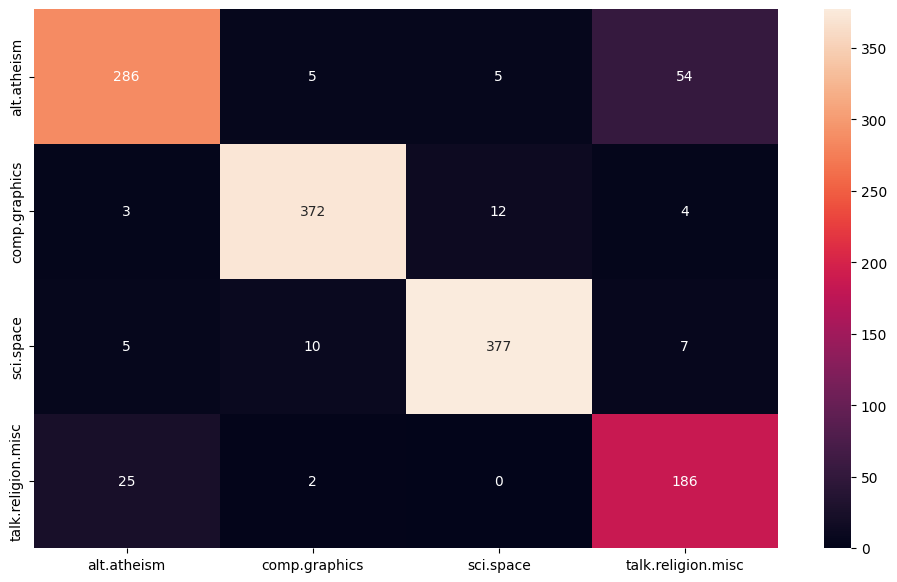

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(12, 7))
sns.heatmap(confusion_matrix(pred, test.target), fmt='d', annot=True, xticklabels=test.target_names, yticklabels=test.target_names)
print(classification_report(test.target, pred, target_names=test.target_names))

In [75]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vec.get_feature_names_out())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.feature_log_prob_[i])[-10:]
        print("%s: [%s]" % (category, ", ".join(feature_names[top10])))

show_top10(clf, vec, train.target_names)

alt.atheism: [article, organization, don, lines, subject, com, writes, people, god, edu]
comp.graphics: [file, posting, university, com, image, organization, graphics, subject, lines, edu]
sci.space: [gov, article, writes, com, lines, organization, subject, nasa, edu, space]
talk.religion.misc: [article, writes, lines, jesus, organization, people, subject, god, com, edu]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных,
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words='english')
trainV = vec.fit_transform(train.data)
testV = vec.transform(test.data)
clf = MultinomialNB()
print(f'mean cross val score: {np.mean(cross_val_score(clf, trainV, train.target, cv=5, scoring="accuracy"))}')


mean cross val score: 0.9257622154173879


In [77]:
clf.fit(trainV, train.target)

pred = clf.predict(testV)

                    precision    recall  f1-score   support

       alt.atheism       0.76      0.92      0.83       319
     comp.graphics       0.95      0.95      0.95       389
         sci.space       0.88      0.97      0.93       394
talk.religion.misc       0.96      0.54      0.69       251

          accuracy                           0.88      1353
         macro avg       0.89      0.85      0.85      1353
      weighted avg       0.89      0.88      0.87      1353



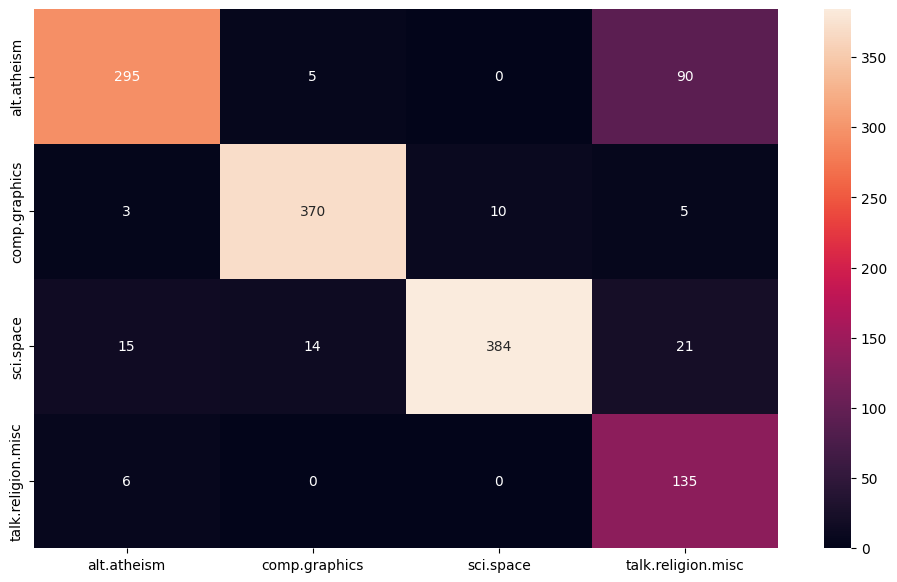

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(12, 7))
sns.heatmap(confusion_matrix(pred, test.target), fmt='d', annot=True, xticklabels=test.target_names, yticklabels=test.target_names)
print(classification_report(test.target, pred, target_names=test.target_names))

In [80]:
show_top10(clf, vec, train.target_names)

alt.atheism: [sgi, livesey, atheists, writes, people, caltech, com, god, keith, edu]
comp.graphics: [organization, thanks, files, subject, com, image, lines, university, edu, graphics]
sci.space: [toronto, moon, gov, com, alaska, access, henry, nasa, edu, space]
talk.religion.misc: [article, writes, kent, people, christian, jesus, sandvik, edu, com, god]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ:

1. некоторые слова могу встречаться в нескольких темах
2. недостаточная предобработка данных
3. возможно, неправильный выбор параметров модели
4. некторые тескты могут содержать множество тем

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.